# Convolutional Neural Network (CNN) to classify handwritten digits using the MNIST dataset

[![Open in GitHub](https://img.shields.io/badge/Open%20in-GitHub-blue?logo=github)](https://github.com/denpalrius/AI-Machine-Learning-Practice/blob/main/mlp/cnn_mnist.ipynb) 
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/denpalrius/AI-Machine-Learning-Practice/blob/main/mlp/cnn_mnist.ipynb)

In [1]:
from ucimlrepo import fetch_ucirepo

import torch
from torch.utils.data import DataLoader, TensorDataset

from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE

from datetime import datetime
import time

# Load the dataset

In [442]:
handwritten_digits = fetch_ucirepo(id=80)

X = handwritten_digits.data.features.to_numpy()
y = handwritten_digits.data.targets.to_numpy()

Visualise the first 5 data items

In [443]:
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0,1,6,15,12,1,0,0,0,7,...,0,0,0,0,6,14,7,1,0,0
1,0,0,10,16,6,0,0,0,0,7,...,3,0,0,0,10,16,15,3,0,0
2,0,0,8,15,16,13,0,0,0,1,...,0,0,0,0,9,14,0,0,0,0
3,0,0,0,3,11,16,0,0,0,0,...,0,0,0,0,0,1,15,2,0,0
4,0,0,5,14,4,0,0,0,0,0,...,12,0,0,0,4,12,14,7,0,0


Visualise 5 digits from the dataset

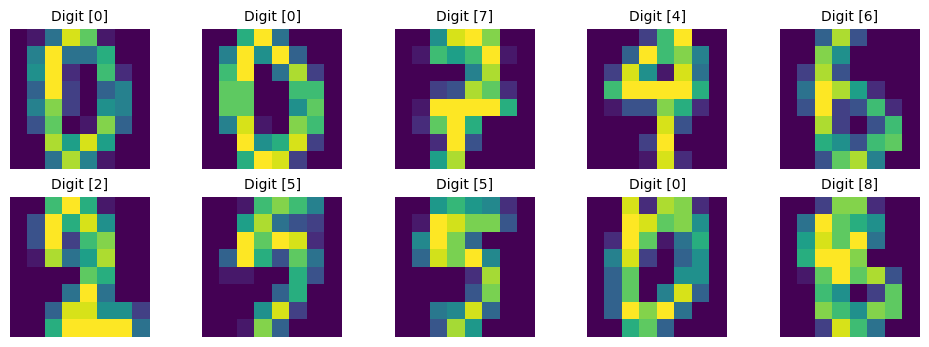

In [444]:
plt.figure(figsize=(12,4))
for index, (image, label) in enumerate(zip(X[0:10], y[0:10])):
    plt.subplot(2, 5, index + 1)
    plt.imshow(np.reshape(image, (8,8)))
    plt.title(f'Digit {label}', fontsize = 10)
    plt.axis('off')
plt.show()

## t-SNE analysis

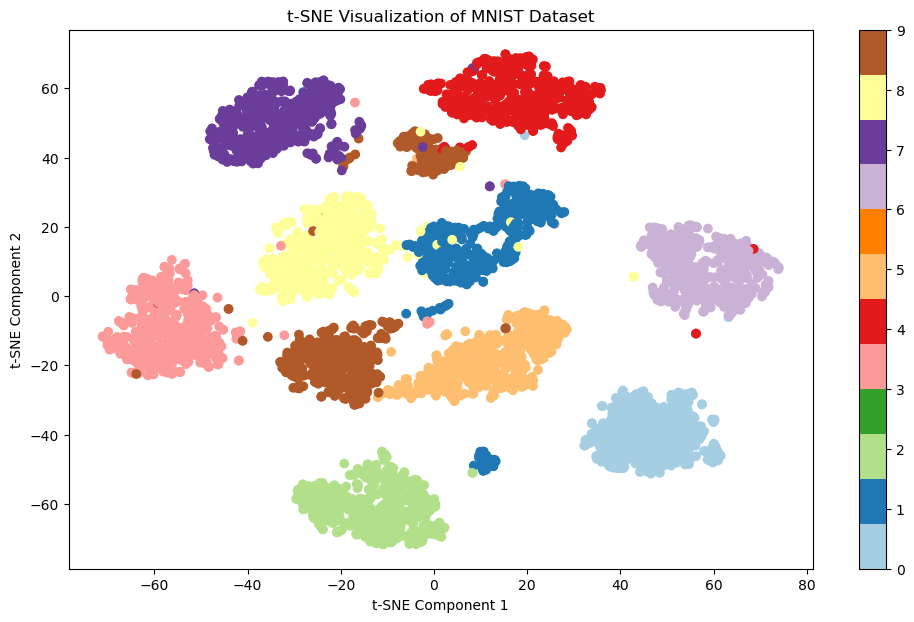

In [445]:
tsne = TSNE(n_components=2, random_state=42)
proj = tsne.fit_transform(X)

plt.figure(figsize=(12, 7))
plt.scatter(proj[:, 0], proj[:, 1], c=y, cmap="Paired")
plt.colorbar(ticks=range(10))
plt.title('t-SNE Visualization of MNIST Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

## Normalise and reshape the features

We will ***normalise*** the pixel values for each image to range between 0 and 1. We do this by dividing the pixel value by 255, the maximum possible pixel value.
This will help in:
- Faster training and convergence of the optimisation
- This will help the model learn with consistent data, capturing underlying patterns instead of being affected by by the scale of the input features

In [446]:
max_pixel = 50
X = X/max_pixel

Reshape data for CNN

In [447]:
dim_size = 8
num_classes = 10
batch_size = dim_size * dim_size

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Dataloader configs
kwargs = {'batch_size': batch_size, 'num_workers': 1, 'pin_memory': False}

Prepare the training, validation and test splits

In [448]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.24, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Reshape the data
X_train = X_train.reshape(-1, 1, dim_size, dim_size)
X_val = X_val.reshape(-1, 1, dim_size, dim_size)
X_test = X_test.reshape(-1, 1, dim_size, dim_size)

# Convert labels to one-hot encoded format
y_train = keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes=num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes=num_classes)

Create the training, validation and test loaders

In [449]:
train_loader = DataLoader(TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train)), shuffle=True, **kwargs)
val_loader = DataLoader(TensorDataset(torch.Tensor(X_val), torch.Tensor(y_val)), shuffle=False, **kwargs)
test_loader = DataLoader(TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test)), shuffle=False, **kwargs)

# Model architecture

Custom CNN Model

In [450]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = torch.nn.Sequential(
            # 1st Convolution layer
            torch.nn.Conv2d(1, 16, kernel_size=2, stride=1, padding=2),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=2),

            # 2nd Convolution layer
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=2),

            # 3rd Convolution layer
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=2),

            # 4th Convolution layer
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=2)
        )

        # Fully connected
        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(512, 128),
            torch.nn.ReLU(True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(128, 10),
            torch.nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output of the convolutional layers
        x = self.fc_layers(x) # Pass through the fully connected layers
        # x = x.view(-1, 1, 8, 8)  # Reshape to match the input size
        return x

# Model training

- The model is trained for multiple epochs on the entire training dataset (*train_loader*).
- Its performance is evaluated on the validation set (*validation_loader*) after each epoch, hence fulling the need for performing ***K-Fold cross-validation*** during the model training.
- This process already provides an estimate of the model's performance on unseen data (the validation set) and helps monitor for overfitting during training.

Accuracy computation function

In [451]:
def get_acc_and_confusion_matrix(model, device, data_loader):
    with torch.no_grad():
        correct_pred = 0
        num_examples = 0
        all_targets =[]
        all_predicted_labels = []

        for features, targets in data_loader:
            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)

            _, predicted_labels = torch.max(logits, 1)
            # Convert predicted_labels to one-hot encoded format to match the 10 classes
            predicted_labels_one_hot = torch.nn.functional.one_hot(predicted_labels, num_classes=num_classes)
            
            # Adjust num_examples for the one-hot encoding
            batch_size = targets.size(0)
            num_examples += batch_size * num_classes
            
            # Convert one-hot encoded labels back to digits (0 to 9) to build the confusion matrix
            targets_digits = torch.argmax(targets, dim=1)
           
            all_targets.extend(targets_digits.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

            correct_pred += (predicted_labels_one_hot == targets).sum()
            
    accuracy = correct_pred.float()/num_examples * 100
    confusion_mat = confusion_matrix(all_targets, all_predicted_labels)
    
    return accuracy, confusion_mat

Training function

In [452]:
def train(model, n_epochs, device, train_loader, validation_loader, optimizer, scheduler):
    start_time = time.time()
    loss_ls = []
    training_accuracy = []
    validation_accuracy = []
    test_accuracy = None
    elapsed_time = 0
    confusion_matrices = []

    for epoch in range(n_epochs):
        model.train()

        for i, (features, targets) in enumerate(train_loader):
            features = features.to(device)
            targets = targets.to(device)

            logits = model(features)

            optimizer.zero_grad()
            loss = criterion(logits, targets)
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            loss_ls.append(loss.item())
            logging_interval = 100

            if not i % logging_interval:
                print(f'Epoch {epoch+1}/{n_epochs} | Batch {i}/{len(train_loader)} | Loss: {loss:.4f}')

        model.eval()

        with torch.no_grad():
            train_acc, train_confusion_matrix = get_acc_and_confusion_matrix(model, device, train_loader)
            valid_acc, val_confusion_matrix = get_acc_and_confusion_matrix(model, device, validation_loader)

            confusion_matrices.append((train_confusion_matrix, val_confusion_matrix))

            print(f'Epoch {epoch+1}/{n_epochs} | ',
                    f'Loss: {loss:.4f} | ', 
                    f'Training Accuracy: {train_acc:.2f}% | ',
                    f'Validation Accuracy: {valid_acc:.2f}%')

            training_accuracy.append(train_acc.item())
            validation_accuracy.append(valid_acc.item())

        elapsed_time = (time.time() - start_time) / 60
        print("Time elapsed: ", elapsed_time, " min")
        scheduler.step(loss_ls[-1])

    elapsed_time = (time.time() - start_time) / 60
    print(f'Total Training Time: {elapsed_time:.2f} min')

    test_accuracy, _ = get_acc_and_confusion_matrix(model, device, test_loader)
    print(f'Test accuracy {test_accuracy :.2f}%')

    return {
        'elapsed_time': elapsed_time,
        'loss_list': loss_ls,
        'training_accuracy': training_accuracy,
        'validation_accuracy': validation_accuracy,
        'testing_accuracy': test_accuracy,
        'confusion_matrices': confusion_matrices
    }

Model training parameters

In [453]:
custom_model = CNN().to(device)
learning_rate = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(custom_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, mode='min')

n_epochs = 35
losses = []

Start the training

In [454]:
train_results = train( custom_model, n_epochs, device, train_loader, val_loader, optimizer, scheduler)

Epoch 1/35 | Batch 0/54 | Loss: 2.3023
Epoch 1/35 |  Loss: 2.3013 |  Training Accuracy: 82.07% |  Validation Accuracy: 81.87%
Time elapsed:  0.09019888242085775  min
Epoch 2/35 | Batch 0/54 | Loss: 2.3004
Epoch 2/35 |  Loss: 2.1211 |  Training Accuracy: 87.94% |  Validation Accuracy: 87.65%
Time elapsed:  0.17441561619440715  min
Epoch 3/35 | Batch 0/54 | Loss: 2.0970
Epoch 3/35 |  Loss: 1.9019 |  Training Accuracy: 89.54% |  Validation Accuracy: 89.64%
Time elapsed:  0.2624093651771545  min
Epoch 4/35 | Batch 0/54 | Loss: 2.0662
Epoch 4/35 |  Loss: 1.9924 |  Training Accuracy: 91.29% |  Validation Accuracy: 91.32%
Time elapsed:  0.34639054934183755  min
Epoch 5/35 | Batch 0/54 | Loss: 1.9263
Epoch 5/35 |  Loss: 1.8989 |  Training Accuracy: 91.91% |  Validation Accuracy: 91.88%
Time elapsed:  0.43033771514892577  min
Epoch 6/35 | Batch 0/54 | Loss: 1.8770
Epoch 6/35 |  Loss: 1.7957 |  Training Accuracy: 92.11% |  Validation Accuracy: 91.95%
Time elapsed:  0.5145143508911133  min
Epoch 

# Training and Validation Metrics

Visualizing the Training loss

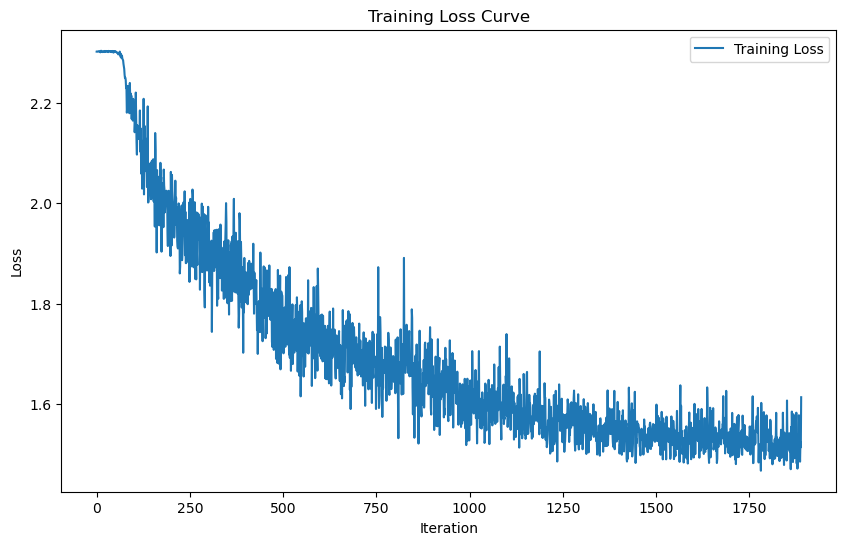

In [455]:
loss_ls = train_results['loss_list']

plt.figure(figsize=(10, 6))
plt.plot(loss_ls, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

Visualizing the training and validation accuracy

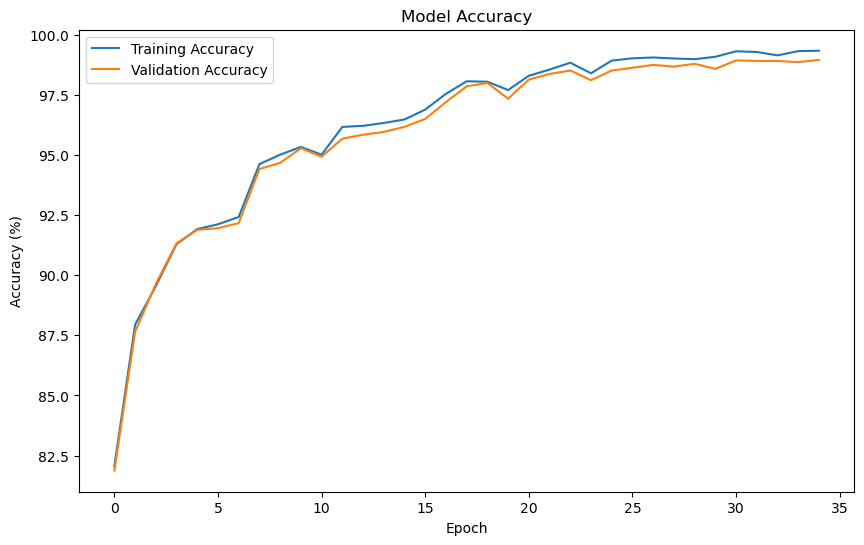

In [456]:
training_accuracy = train_results['training_accuracy']
validation_accuracy = train_results['validation_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy')
plt.legend()
plt.show()

Testing accuracy

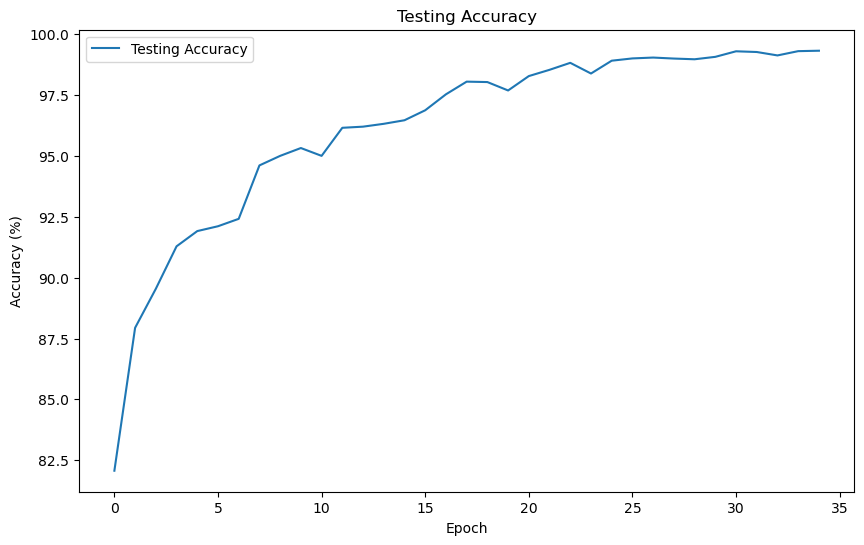

In [457]:
testing_accuracy = train_results['testing_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(training_accuracy, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Testing Accuracy')
plt.legend()
plt.show()

Visualising the confusion matrix for the last validation run

In [458]:
validation_confusion_matrices = train_results['confusion_matrices'][1]
confusion_matrix = validation_confusion_matrices[-1]

print(confusion_matrix)

[[48  0  0  0  0  8 40  0  0  0]
 [ 0 62  0  0  0  7  5  6  0  0]
 [12 16  0  0  0 66  2 11  0  0]
 [ 0 12  0  0  0 14  0 64  0  0]
 [ 2  9  0  0  0 15 52  0  0  0]
 [ 6  2  0  0  0 68  0  8  0  0]
 [ 0  0  0  0  0  0 79  0  0  0]
 [ 0  3  0  0  0  1  0 70  0  0]
 [ 2 22  0  0  0 49  3  4  0  0]
 [ 0  6  0  0  0 57  0 24  0  0]]


# Model Testing

Evaluationn function

In [459]:
def evaluate(model, device, test_loader, criterion, num_classes):
    model.eval()
    
    test_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_targets = []
    all_predicted_labels = []

    with torch.no_grad():
        for features, targets in test_loader:
            features = features.to(device)
            targets = targets.to(device)

            logits = model(features)

            loss = criterion(logits, targets)
            test_loss += loss.item() * features.size(0)

            _, predicted_labels = torch.max(logits, 1)

            # Convert predicted_labels to one-hot encoded format to match the number of classes
            predicted_labels_one_hot = torch.nn.functional.one_hot(predicted_labels, num_classes=num_classes)


            # Convert one-hot encoded labels back to digits (0 to 9) to build the confusion matrix
            targets_digits = torch.argmax(targets, dim=1)
           
            # Update correct_predictions count
            correct_predictions += (predicted_labels == targets_digits).sum().item()

            # Update total_samples count
            total_samples += targets.size(0)

            all_targets.extend(targets_digits.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    accuracy = (correct_predictions / total_samples) * 100
    
    confusion_mat = sk_confusion_matrix(all_targets, all_predicted_labels)

    return test_loss, accuracy, confusion_mat

Evaluate the model

In [460]:
test_loss, accuracy, confusion_mat = evaluate(custom_model, device, test_loader, criterion, num_classes)

print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {accuracy:.2f} % \n')

print('---------------- \n')

print('Confusion Matrix:')
print(confusion_mat)

# The SNS heatmap had an issue so I have not used it

Test loss: 1.5165
Test accuracy: 94.59 % 

---------------- 

Confusion Matrix:
[[124   0   0   0   0   4   0   0   1   0]
 [  0 131   0   0   2   0   0   1   2   2]
 [  0   1 119   1   0   0   0   0   1   1]
 [  0   0   1 125   0   5   0   0   0   4]
 [  0   1   0   0 140   0   1   0   0   0]
 [  2   0   0   1   1 116   0   0   0   2]
 [  1   1   0   0   0   0 137   0   1   0]
 [  0   0   0   1   0   0   0 149   0   3]
 [  0   1   2   1   5   5   0   0 107   4]
 [  0   0   1   1   1   5   0   4   2 128]]


# Tensorflow and Keras Model for comparative analysis

Keras CNN model

In [461]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.24, random_state=42)

X_train = X_train.reshape(-1, 8, 8, 1)
X_test = X_test.reshape(-1, 8, 8, 1)

y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [462]:
keras_model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(8, 8, 1)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

/Users/mzitoh/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Compile the model

In [463]:
keras_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Train the model

In [464]:
history = keras_model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2684 - loss: 2.1441 - val_accuracy: 0.8364 - val_loss: 0.7501
Epoch 2/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8641 - loss: 0.5313 - val_accuracy: 0.9019 - val_loss: 0.2956
Epoch 3/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9174 - loss: 0.2831 - val_accuracy: 0.9182 - val_loss: 0.2299
Epoch 4/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9335 - loss: 0.2052 - val_accuracy: 0.9346 - val_loss: 0.1684
Epoch 5/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9367 - loss: 0.2055 - val_accuracy: 0.9696 - val_loss: 0.0973
Epoch 6/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9671 - loss: 0.1122 - val_accuracy: 0.9790 - val_loss: 0.0824
Epoch 7/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9699 - loss: 0.0995 - val_accuracy: 0.9743 - val_loss: 0.0813
Epoch 8/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9742 - loss: 0.0902 - val_accuracy: 0.9813 - val_loss:

Visualise training metrics

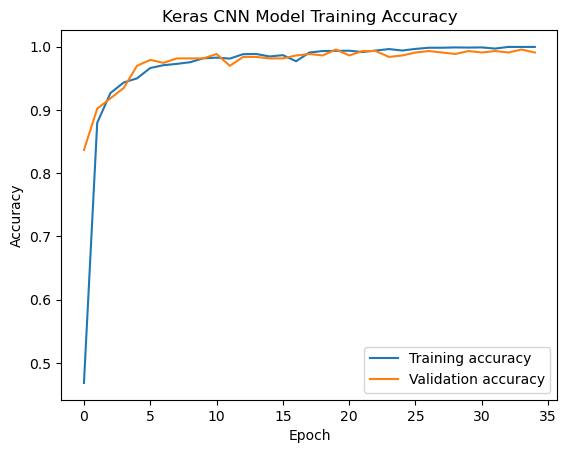

In [465]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Keras CNN Model Training Accuracy')
plt.legend()
plt.show()

Evaluate the model

In [466]:
loss, accuracy = keras_model.evaluate(X_test, y_test)

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9873 - loss: 0.0418
Loss: 0.0579
Accuracy: 0.9852


# References

[1] PyTorch. (n.d.). CIFAR-10 Tutorial. PyTorch Tutorials. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

[2] A. Bose, “A must read intro to neural networks using pytorch - handwritten digit recognition,” Medium, https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627 (accessed May 4, 2024). 